<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4
*Pick one of the examples of the chapter that use the data of the book and replicate it in Python. Then, apply the steps in your own data.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing)

In [137]:
from ssl import OP_SINGLE_DH_USE
import numpy as np
import pandas as pd
import itertools
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,confusion_matrix, accuracy_score, r2_score, ConfusionMatrixDisplay
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import linalg
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline

## Regresión logística en predicción de enfermedades cardiacas
A continuación repetiremos el ejemplo 4.4.2 de predicción de enfermedad cardiaca en Sudafrica **(South African Heart Disease)** del [libro](https://link.springer.com/book/10.1007/978-0-387-84858-7).

Iniciamos cargando los datos de entrenamiento y almacenamos en `y_train`:

In [138]:
## Procesamos datos de entrenamiento 
df = pd.read_csv('SAheart.csv')
df=df.assign(const=1)
print(df)
dfy = df['chd'] 
dfx = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

## Procesamos datos de prueba 
dfyt = df['chd'] 
dfxt = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

     row.names  sbp  tobacco    ldl  ...  alcohol  age  chd  const
0            1  160    12.00   5.73  ...    97.20   52    1      1
1            2  144     0.01   4.41  ...     2.06   63    1      1
2            3  118     0.08   3.48  ...     3.81   46    0      1
3            4  170     7.50   6.41  ...    24.26   58    1      1
4            5  134    13.60   3.50  ...    57.34   49    1      1
..         ...  ...      ...    ...  ...      ...  ...  ...    ...
457        459  214     0.40   5.98  ...     0.00   58    0      1
458        460  182     4.20   4.41  ...    18.72   52    1      1
459        461  108     3.00   1.59  ...    26.64   55    0      1
460        462  118     5.40  11.61  ...    23.97   40    0      1
461        463  132     0.00   4.82  ...     0.00   46    1      1

[462 rows x 12 columns]


In [139]:
X_train = dfx.to_numpy()   
X_train = sm.add_constant(X_train)
y_train = dfy.to_numpy()  
X_test  = dfxt.to_numpy()   
X_test = sm.add_constant(X_train)
y_test  = dfyt.to_numpy()   
#X_train.tofile('sample.csv',sep=',')

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión logística de la librería **statsmodels**. Como podemos ver algunas de las variables resultan ser no significativas con un valor P menor que 0.05. Tal es el caso de *alcohol, obesity, adiposity* y *sbp*. 

In [140]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.522778
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            8
Date:                Mon, 31 Jan 2022   Pseudo R-squ.:                  0.1897
Time:                        04:52:36   Log-Likelihood:                -241.52
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 8.931e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9658      1.068     -3.715      0.000      -6.058      -1.873
sbp            0.0056      0.

De acuerdo con el libro, se aplicó una técnica de reducción de variables paso a paso **(Stepwise)** en el se encuentra un subconjunto de las variables que son suficientes para explicar el efecto conjunto de los predictores sobre la variable *chd*. El procedimiento descarta el coeficiente P menos significativo `pmenor` y el modelo se reajusta. Esto se hace repetidamente hasta que no se puedan eliminar más variables del modelo.
Los resultados obtenidos en la tabla coinciden con los del libro.


In [141]:
# Se ordenan los valores p y se selecciona el más pequeño
p_values = results.pvalues.sort_values(ascending = False)
pmenor = p_values.head(1)

print("menorpi.item() ", pmenor.item())

## Proceso de stepwise
while pmenor.item() > 0.01:
    print(pmenor.index.tolist())
    dfx = dfx.drop(pmenor.index.tolist(), axis=1)
    model = sm.Logit(dfy, dfx)
    model = model.fit()
    # Se ordenan los valores p y se selecciona el más pequeño
    p_values = model.pvalues.sort_values(ascending = False)
    pmenor = p_values.head(1)

print(model.summary())

menorpi.item()  0.9062256410652616
['alcohol']
Optimization terminated successfully.
         Current function value: 0.522793
         Iterations 6
['adiposity']
Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6
['sbp']
Optimization terminated successfully.
         Current function value: 0.524131
         Iterations 6
['obesity']
Optimization terminated successfully.
         Current function value: 0.525372
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Mon, 31 Jan 2022   Pseudo R-squ.:                  0.1856
Time:                        04:52:39   Log-Likelihood:                -242.72
converged:                       True

Finalmente, evaluamos el desempeño del modelo calculando la exactitud y la matriz de confusión.

In [142]:
yhat       = model.predict(dfx)
prediction = list(map(round, yhat))

# Calculamos la matriz de confusión
cm = confusion_matrix(dfy, prediction)
print ("Confusion Matrix : \n", cm)
 
# Exactitud del modelo
print('Test accuracy = ', accuracy_score(dfy, prediction))

Confusion Matrix : 
 [[254  48]
 [ 76  84]]
Test accuracy =  0.7316017316017316


Otra manera de calcular una regresión logística es con la librería **sklearn** tal como se muestra a continuación.

In [143]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.predict(X_test[0].reshape(1,-1))
logisticRegr.predict(X_test[0:10])
predictions = logisticRegr.predict(X_test)
error = y_test - predictions
## Utilice el método de score para obtener la precisión del modelo
score = logisticRegr.score(X_test, y_test)
parametros=logisticRegr.get_params(deep=False)
print(score)

0.7229437229437229


## Análisis Discriminante Lineal y Cuadrático con datos de prueba en dos dimensiones
Haremos algunas pruebas con datos de un ejemplo de dos dimensiones para predecir un conjunto de datos divididos en tres clases [1,2,3] usando el Análisis Discriminante Lineal **(LDA)** y Análisis Discriminante Cuadrático **(QDA)**. Usaremos la librería **sklearn**.

In [144]:
## Leemos los datos 
df = pd.read_csv('clusters.csv')
dfy = df['y'] 
dfx = df[['X1','X2']] #dfx = dfx.assign(const=1)
#Estandarizamos los datos
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dfx = pd.DataFrame(scaler.fit_transform(dfx), columns=dfx.columns)
X = dfx.to_numpy()
#X = sm.add_constant(X) ## para agregar una constante en uno
y = dfy.to_numpy()

In [145]:
## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 5)

Iniciamos aplicando un test de **ANCOVA** de análisis de covarianza a nuestros datos.

In [146]:
reg = ols('y~X1+X2',data=df).fit()
aov = sm.stats.anova_lm(reg,type=2) # Type 2 Anova DataFrame
print(aov)

              df      sum_sq     mean_sq             F         PR(>F)
X1           1.0  913.663458  913.663458  22731.238484   0.000000e+00
X2           1.0   26.165857   26.165857    650.986230  1.587698e-119
Residual  1497.0   60.170685    0.040194           NaN            NaN


Ahora aplicamos el método de **LDA** y obtenemos la exactitud **(score)**.

In [147]:
LDA_model = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
LDA_model.fit(X_test, y_test)
y_pred_LDA = LDA_model.predict(X_test)
score = LDA_model.score(X_test, y_test)
parametros = LDA_model.get_params(deep=False)
print(score)

0.9906666666666667


In [148]:
def plot_ellipse(mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2*v[0]**0.5, 2*v[1]**0.5, 180 + angle,
                              facecolor=color,edgecolor="black",linewidth=2,)
    #ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    return ell

Se dibuja un diagrama un dispersión con la separación por hiperplanos y los intervalos de confianza de cada clase al 95% (elipses) para el método **LDA**.

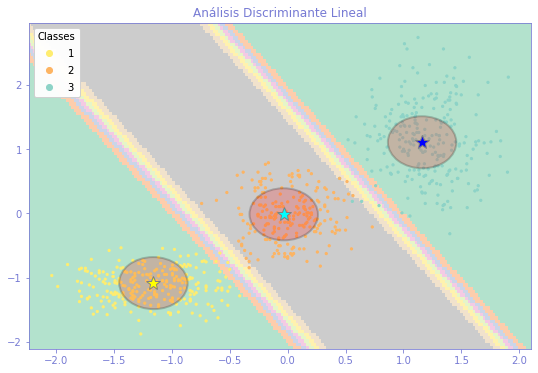

In [149]:
## Se dibuja diagrama un dispersión con la separación por hiperplanos y el intervalo de confianza al 95%
fig, ax = plt.subplots(figsize=(9,6))
scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=5)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")
ax.add_artist(legend1)
listcolor=["yellow","cyan","blue"]
for i in range(len(LDA_model.means_)):
    plt.plot(LDA_model.means_[i][0], LDA_model.means_[i][1],
    "*", color=listcolor[i], markersize=15, markeredgecolor="grey",)

nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = LDA_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#cmap= Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2
plt.pcolormesh(xx, yy, Z, cmap='Pastel2', norm=colors.Normalize(0.0, 1.0), zorder=0)
for i in range(len(LDA_model.means_)):
    ell=plot_ellipse(LDA_model.means_[i],LDA_model.covariance_,"red")
    ax.add_patch(ell)

#ax = plt.axes()   # get the axis property handler          # plt.getp(myax) print its propieties
mytitle = plt.title("Análisis Discriminante Lineal") # get the title property handler   #plt.getp(title_obj)  
plt.setp(mytitle, color='#777bd4')                          # set the color of title
ax.xaxis.label.set_color('#777bd4')
ax.yaxis.label.set_color('#777bd4')
ax.tick_params(colors='#777bd4', which='both')              # myax.spines['bottom'].set_color('yellow')
ax.spines['bottom'].set_color('#777bd4')
ax.spines['top'].set_color('#777bd4') 
ax.spines['right'].set_color('#777bd4')
ax.spines['left'].set_color('#777bd4')
plt.savefig('scatter1.png', transparent=True)
plt.show()

Graficamos la matriz de confusión del modelo **LDA**.


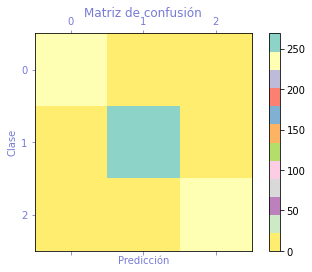

Matriz de confusión
[[228   3   0]
 [  1 269   1]
 [  0   2 246]]


In [150]:
title = "Matriz de confusión"
cm = confusion_matrix(y_test, y_pred_LDA)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
#cmap= Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2
plt.set_cmap('Pastel1')
plt.xlabel('Predicción')
plt.ylabel('Clase')
mytitle = plt.title(title)     # get the title property handler   #plt.getp(title_obj)  
plt.setp(mytitle, color= '#777bd4')             # set the color of title
ax.xaxis.label.set_color('#777bd4')
ax.yaxis.label.set_color('#777bd4')
ax.tick_params(colors='#777bd4', which='both') # myax.spines['bottom'].set_color('yellow')

plt.savefig('confusion1.png', transparent=True)
plt.show()
print(title)
print(cm)

Ahora, aplicamos un modelo **QDA** y obtenemos la exactitud **(score)**.

In [151]:
QDA_model = QuadraticDiscriminantAnalysis(store_covariance=True)
QDA_model.fit(X_test, y_test)
y_pred_QDA = QDA_model.predict(X_test)
y_pred_QDA.tofile('predictionQDA.csv',sep=',')
score = QDA_model.score(X_test, y_test)
parametros = QDA_model.get_params(deep=False)
print(score)

0.9933333333333333


Se dibuja un diagrama un dispersión con la separación por hiperplanos y los intervalos de confianza de cada clase al 95% (elipses) para el método **QDA**.

[[0.13 0.01]
 [0.01 0.06]]
[[ 0.07 -0.  ]
 [-0.    0.12]]
[[ 0.07 -0.  ]
 [-0.    0.31]]


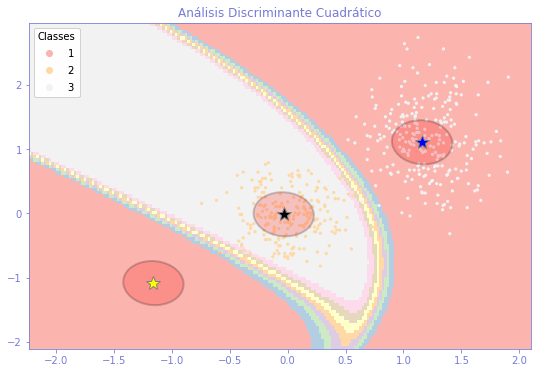

In [152]:
fig, ax = plt.subplots(figsize=(9,6))
scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=5)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")
ax.add_artist(legend1)
listcolor=["yellow","black","blue"]
for i in range(len(QDA_model.means_)):
    plt.plot(QDA_model.means_[i][0], QDA_model.means_[i][1],
    "*", color=listcolor[i], markersize=15, markeredgecolor="grey",)
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = QDA_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
#cmap= Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2
plt.pcolormesh(xx, yy, Z, cmap="Pastel1", norm=colors.Normalize(0.0, 1.0), zorder=0)

for i in range(len(QDA_model.means_)):
    print(QDA_model.covariance_ [i])
    ell=plot_ellipse(QDA_model.means_[i],QDA_model.covariance_[1],"red")
    ax.add_patch(ell)

#ax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
mytitle = plt.title("Análisis Discriminante Cuadrático") # get the title property handler   #plt.getp(title_obj)  
plt.setp(mytitle, color='#777bd4')                            # set the color of title
ax.xaxis.label.set_color('#777bd4')
ax.yaxis.label.set_color('#777bd4')
ax.tick_params(colors='#777bd4', which='both')              # myax.spines['bottom'].set_color('yellow')
ax.spines['bottom'].set_color('#777bd4')
ax.spines['top'].set_color('#777bd4') 
ax.spines['right'].set_color('#777bd4')
ax.spines['left'].set_color('#777bd4')

plt.savefig('scatter2.png', transparent=True)
plt.show()

Graficamos la matriz de confusión del modelo **QDA**

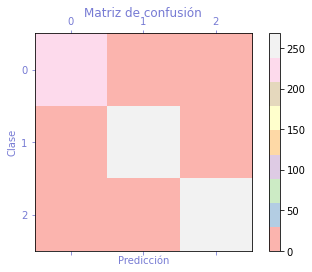

Matriz de confusión
[[230   1   0]
 [  2 268   1]
 [  0   1 247]]


In [153]:
np.set_printoptions(precision=2)
title = "Matriz de confusión"
cm = confusion_matrix(y_test, y_pred_QDA)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.xlabel('Predicción')
plt.ylabel('Clase')
mytitle = plt.title(title)     # get the title property handler   #plt.getp(title_obj)  
plt.setp(mytitle, color='#777bd4')             # set the color of title
ax.xaxis.label.set_color('#777bd4')
ax.yaxis.label.set_color('#777bd4')
ax.tick_params(colors='#777bd4', which='both') # myax.spines['bottom'].set_color('yellow')
#cmap= Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2
plt.set_cmap('Pastel2')

plt.savefig('confusion2.png', transparent=True)
plt.show()
print(title)
print(cm)

## Análisis Discriminante Lineal y Cuadrático aplicada a clasificación de regiones de consumo de electricidad.
Los datos que se usarán en este ejercicio son resultados de la planeación de la operación eléctrica del sistema eléctrico interconectado en México que consta de 320 instancias. Las columnas de los datos son los resultados por región y por hora del día. Se dan resultados de generación térmica (GenTer), generación hidráulica (GenHid), generación renovable (GenRE), Gneración no programable (GenNP), Generación total (GenTot), demanda de la región (Demanda), Cortes de energía (Corte), Excedentes de energía(Excedente),Potencia (PotInt), precio Marginal y pérdidas de la región.

La clases [1,2,3,4,..,67] son las regiones y los regresores son ['GenTer','GenHid','GenRE','GenNP','Demanda','Perdidas','PrecioMarginal'].



In [154]:
## Procesamos datos
df = pd.read_csv('r_Regiones_100s_train.csv')
df = df.assign(const=1)
dfy = df['Clase'] 
dfx = df[['GenTer','GenHid','GenRE','GenNP','Demanda','Perdidas','PrecioMarginal']]  ## Predictors
## Estandarizamos los datos
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dfx = pd.DataFrame(scaler.fit_transform(dfx), columns=dfx.columns)
X = dfx.to_numpy() 
## X = sm.add_constant(X) ## para agregar una constante en uno
y = dfy.to_numpy()

In [155]:
## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.70, random_state = 5)

A continuación se muestra una proyección de los datos entre las variables ['GenTer'] ['Demanda']

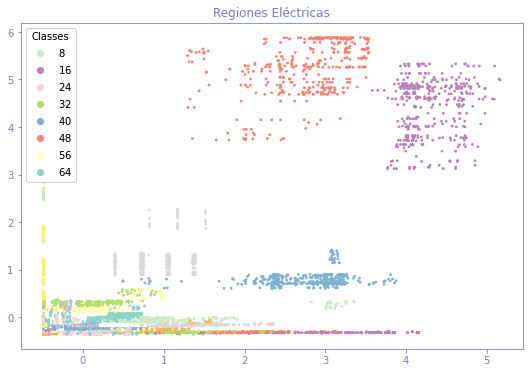

In [156]:
title = "Regiones Eléctricas"
fig, ax = plt.subplots(figsize=(9,6))
#cmap= Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2, Blues
scatter = ax.scatter(X_train[:,0], X_train[:,4], c=y_train, s=3,cmap=plt.cm.Set3_r )
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")
ax.add_artist(legend1)

#ax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
mytitle = plt.title(title) # get the title property handler  #plt.getp(title_obj)  
plt.setp(mytitle, color= '#777bd4')                          # set the color of title
ax.xaxis.label.set_color('#777bd4')
ax.yaxis.label.set_color('#777bd4')
ax.tick_params(colors='#777bd4', which='both')               # myax.spines['bottom'].set_color('yellow')

ax.spines['bottom'].set_color('#777bd4')
ax.spines['top'   ].set_color('#777bd4') 
ax.spines['right' ].set_color('#777bd4')
ax.spines['left'  ].set_color('#777bd4')
plt.savefig('scatter3.png', transparent=True)
plt.savefig('scatter4.png', transparent=True)
plt.show()

Iniciamos aplicando un test de **ANCOVA** de análisis de covarianza a nuestros datos.

In [157]:
reg = ols('GenTer~GenHid+GenRE+GenNP+Demanda+Perdidas+PrecioMarginal',data=df).fit()
aov = sm.stats.anova_lm(reg,type=2) # Type 2 Anova DataFrame
print(aov)

                     df        sum_sq       mean_sq             F        PR(>F)
GenHid              1.0  1.447110e+07  1.447110e+07     70.167814  5.518693e-17
GenRE               1.0  2.544945e+09  2.544945e+09  12339.991992  0.000000e+00
GenNP               1.0  1.022426e+09  1.022426e+09   4957.566027  0.000000e+00
Demanda             1.0  7.146483e+09  7.146483e+09  34652.045727  0.000000e+00
Perdidas            1.0  1.270280e+09  1.270280e+09   6159.367386  0.000000e+00
PrecioMarginal      1.0  1.460320e+07  1.460320e+07     70.808371  3.989542e-17
Residual        96473.0  1.989616e+10  2.062355e+05           NaN           NaN


Ahora aplicamos el método de **LDA** y obtenemos la exactitud **(score)**.

In [158]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_test, y_test)
y_pred_LDA = LDA_model.predict(X_test)
print(y_pred_LDA)
score  = LDA_model.score(X_test, y_test)
params = LDA_model.get_params(deep=False)
print(score)

[44 44 29 ... 65  8 16]
0.576048329779673


Ahora, aplicamos un modelo **QDA** y obtenemos la exactitud **(score)**.

In [159]:
QDA_model = QuadraticDiscriminantAnalysis()
QDA_model.fit(X_test, y_test)
y_pred_QDA = QDA_model.predict(X_test)
print(y_pred_QDA)
score  = QDA_model.score(X_test, y_test)
params = QDA_model.get_params(deep=False)
print(score)

[13 34 17 ... 62 47 16]
0.36204394693200664


Se dibuja un diagrama un dispersión con la separación por hiperplanos y los intervalos de confianza de cada clase al 95% (elipses) para el método **QDA**.

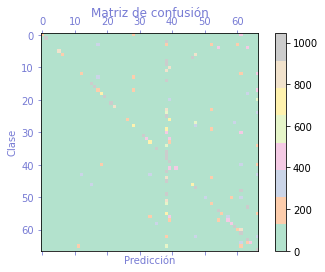

Matriz de confusión
[[ 193    0    0 ...    0    0    0]
 [   0  983    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...  427    0    0]
 [  22    0    0 ...    0   55    0]
 [   0    0    0 ...    0    0 1006]]


In [160]:
np.set_printoptions(precision=2)
title = "Matriz de confusión"
cm = confusion_matrix(y_test, y_pred_QDA)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.xlabel('Predicción')
plt.ylabel('Clase')
mytitle = plt.title(title)     # get the title property handler   #plt.getp(title_obj)  
plt.setp(mytitle, color='#777bd4')             # set the color of title
ax.xaxis.label.set_color('#777bd4')
ax.yaxis.label.set_color('#777bd4')
ax.tick_params(colors='#777bd4', which='both') # myax.spines['bottom'].set_color('yellow')
#cmap = Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2
plt.set_cmap('Set3_r')

plt.savefig('confusion3.png', transparent=True)
plt.show()
print(title)
print(cm)

Esta es otra manera de trazar el mismo diagrama de confusión.

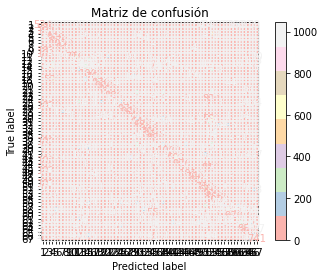

Matriz de confusión
[[ 534    0    0 ...    0   59    0]
 [   0  999    0 ...    0    0    0]
 [   0    0 1044 ...    0    0    0]
 ...
 [   0    0    0 ...  909   15    0]
 [  17    0    0 ...    0  147    0]
 [   0    0    0 ...  169    0  741]]


In [161]:
np.set_printoptions(precision=2)
title = "Matriz de confusión"
#cmap= Pastel2, Set3_r, Pastel1, coolwarm, Set3_r, Set2
disp = ConfusionMatrixDisplay.from_estimator(LDA_model, 
       X_test, y_test, cmap=plt.cm.Pastel1,)#display_labels=["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"]
disp.ax_.set_title(title)
plt.show()
print(title)
print(disp.confusion_matrix)

## Alguna ligas útiles que se utilizaron se pueden encontrar aquí

1. [Ejemplo de grafica de LDA Y QDA de scikit-learn.org ](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html)  
2.  [Análisis Discriminante Lineal y Cuadrático de scikit-learn.org](https://scikit-learn.org/stable/modules/lda_qda.html) 
3. [Análisis Discriminante Lineal y Cuadrático de datasklr.com](https://www.datasklr.com/select-classification-methods/linear-and-quadratic-discriminant-analysis)
4. [Regresión logística usando Python (scikit-learn)
](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a)
5. [Cómo realizar análisis de covarianza (ANCOVA) en Python](https://www.youtube.com/watch?v=aJcIMwVOLeA)
6. [Cómo realizar una Matriz de confusión con Matplotlib](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html?highlight=confusion%20matrix)
6. [Cómo editar una Matriz de confusión (stackoverflow)](https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels)


